In [8]:
import cv2
import warnings
import numpy as np
import multiprocessing
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

In [15]:
def getDisparity(left_img, right_img, patch_radius, min_disp, max_disp):
    """
    left_img and right_img are both H x W and you should return a H x W matrix containing the disparity d for
    each pixel of left_img. Set disp_img to 0 for pixels where the SSD and/or d is not defined, and for
    d estimates rejected in Part 2. patch_radius specifies the SSD patch and each valid d should satisfy
    min_disp <= d <= max_disp.
    """
    r = patch_radius
    patch_size = 2 * patch_radius + 1

    disp_img = np.zeros_like(left_img).astype(float)
    rows, cols = left_img.shape

    debug_ssds = False
    reject_outliers = True
    refine_estimate = True

    # pool = multiprocessing.Pool(processes=4)
    # pool.map(func, range(10))
    # pool.close()
    # pool.join()

    for row in range(patch_radius, rows - patch_radius):
        for col in range(max_disp + patch_radius, cols - patch_radius):
            # Here we construct what you can see in the left two subplots of Fig. 4.
            left_patch = left_img[(row - r):(row + r + 1), (col - r):(col + r + 1)]
            right_strip = right_img[(row - r):(row + r + 1), (col - r - max_disp):(col + r - min_disp + 1)]

            rsvecs = np.zeros([patch_size, patch_size, max_disp - min_disp + 1])
            for i in range(0, patch_size):
                rsvecs[:, i, :] = right_strip[:, i:(max_disp - min_disp + i + 1)]

            # Transforming the patches into vectors so we can run them through pdist2.
            lpvec = left_patch.flatten()
            rsvecs = rsvecs.reshape([patch_size**2, max_disp - min_disp + 1])

            ssds = cdist(lpvec[None, :], rsvecs.T, 'sqeuclidean').squeeze(0)

            if debug_ssds:
                plt.figure(figsize=(15, 4))
                plot1 = plt.subplot2grid((1, 4), (0, 0))
                plot2 = plt.subplot2grid((1, 4), (0, 1), colspan=2)
                plot3 = plt.subplot2grid((1, 4), (0, 3))

                plot1.imshow(left_patch)
                plot1.axis('off')
                plot2.imshow(right_strip)
                plot2.axis('off')

                plot3.plot(ssds)
                plt.xlabel('d-d_{max}')
                plt.ylabel('SSD')

                plt.tight_layout()
                plt.show()

            # The way the patches are set up, the argmin of ssds will not directly be the disparity,
            # but rather (max_disparity - disparity). We call this "neg_disp".
            neg_disp = np.argmin(ssds)
            min_ssd = ssds[neg_disp]

            if reject_outliers:
                if (ssds <= 1.5 * min_ssd).sum() < 3 and neg_disp != 0 and neg_disp != ssds.shape[0] - 1:
                    if not refine_estimate:
                        disp_img[row, col] = max_disp - neg_disp
                    else:
                        x = np.asarray([neg_disp - 1, neg_disp, neg_disp + 1])
                        p = np.polyfit(x, ssds[x], 2)

                        # Minimum of p(0)x^2 + p(1)x + p(2), converted from neg_disp to disparity as above.
                        disp_img[row, col] = max_disp + p[1] / (2 * p[0])
            else:
                disp_img[row, col] = max_disp - neg_disp
    return disp_img


def disparityToPointCloud(disp_img, K, baseline, left_img):
    """
    points should be Nx3 and intensities N, where N is the amount of pixels which have a valid disparity.
    I.e., only return points and intensities for pixels of left_img which have a valid disparity estimate!
    The i-th intensity should correspond to the i-th point.
    """
    h, w = disp_img.shape
    # Convenient way to build per-pixel coordinates.
    X, Y = np.meshgrid(np.arange(1, w + 1), np.arange(1, h + 1))
    X, Y = X.reshape(h*w), Y.reshape(h*w)
    px_left = np.stack([X, Y, np.ones_like(X)], axis=-1).astype(float)

    # Corresponding pixels in right image = pixel coords in left img minus disparity.
    px_right = px_left.copy()
    px_right[:, 0] -= disp_img.reshape(h*w)
    
    # Filter out pixels that do not have a known disparity.
    invalid_disp = disp_img.reshape(h*w) > 0
    px_left = px_left[invalid_disp, :]
    px_right = px_right[invalid_disp, :]
    intensities = left_img[invalid_disp.reshape([h, w])]
    
    # Reproject pixels: Get bearing vectors of rays in camera frame.
    K_inv = np.linalg.inv(K)
    bv_left = np.matmul(K_inv, px_left[:, :, None]).squeeze(-1)
    bv_right = np.matmul(K_inv, px_right[:, :, None]).squeeze(-1)

    # Intersect rays according to formula in problem statement.
    b = np.asarray([baseline, 0, 0])

    A = np.stack([bv_left, -bv_right], axis=-1)
    A_pseudo_inv = np.linalg.inv(np.matmul(A.transpose([0, 2, 1]), A))
    lambda_variable = np.matmul(A_pseudo_inv, np.matmul(A.transpose([0, 2, 1]), b[:, None]))

    points = bv_left * lambda_variable[:, 0, :]
    return points, intensities

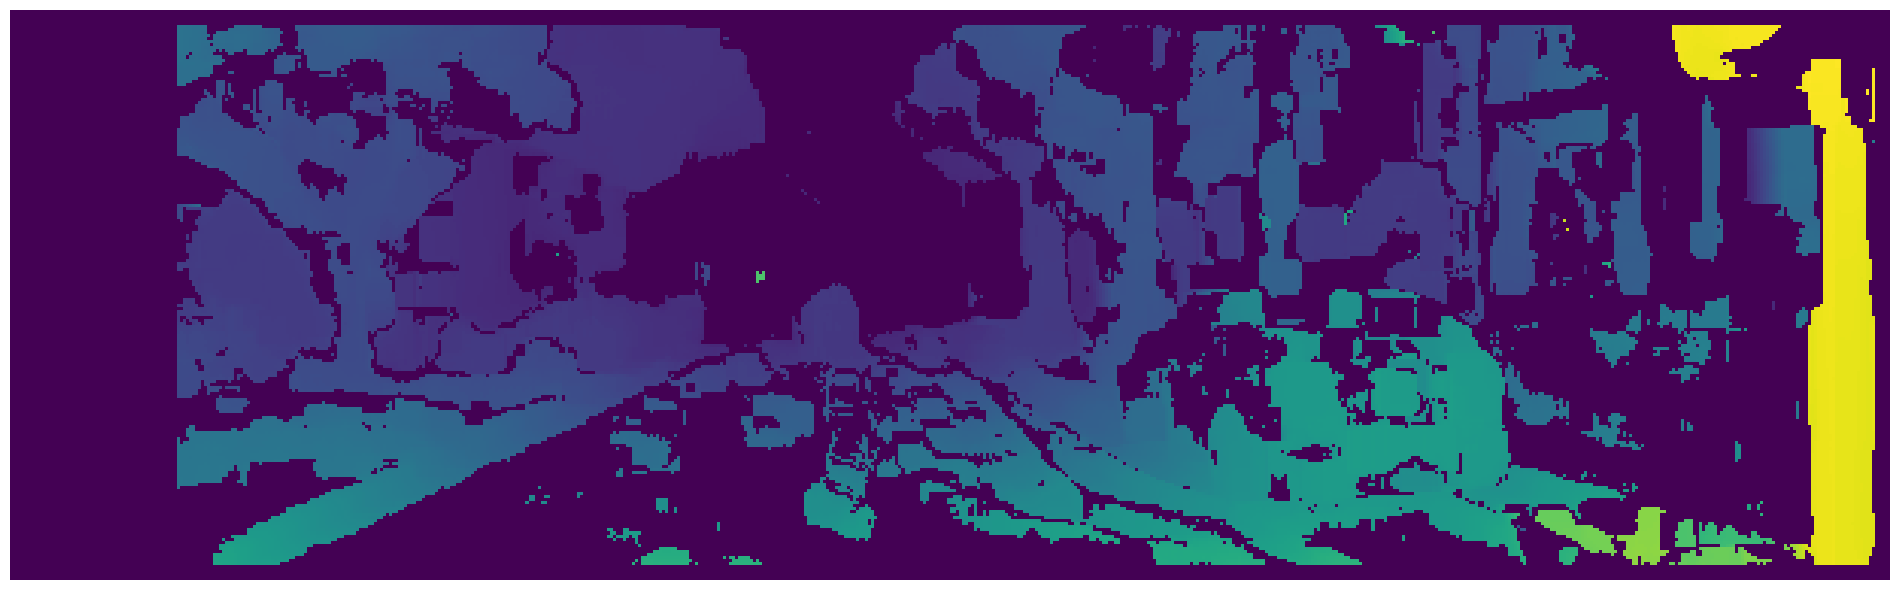

In [11]:
# Scaling down by a factor of 2, otherwise too slow.
left_img = cv2.resize(cv2.imread('./data/left/000000.png', cv2.IMREAD_GRAYSCALE), None,fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
right_img = cv2.resize(cv2.imread('./data/right/000000.png', cv2.IMREAD_GRAYSCALE), None,fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
K = np.loadtxt('./data/K.txt')
K[0:2, :] /= 2

poses = np.loadtxt('./data/poses.txt')

# Given by the KITTI dataset:
baseline = 0.54

# Carefully tuned by the TAs:
patch_radius = 5
min_disp = 5
max_disp = 50
xlims = [7, 20]
ylims = [-6, 10]
zlims = [-5, 5]

# Parts 1, 2 and 4: Disparity on one image pair
disp_img = getDisparity(left_img, right_img, patch_radius, min_disp, max_disp)

plt.figure(figsize=(24,6))
plt.imshow(disp_img)
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipykernel_655/1955444445.py:2: UserWarning: Visualizing disparity over sequence! This is optional and could take a lot of time (100 stereo pairs)!
  warnings.warn('Visualizing disparity over sequence! This is optional and could take a lot of time (100 stereo pairs)!')


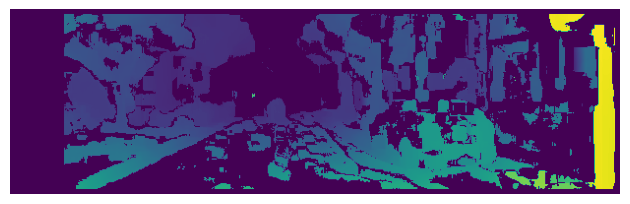

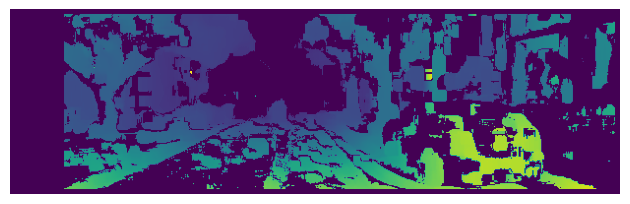

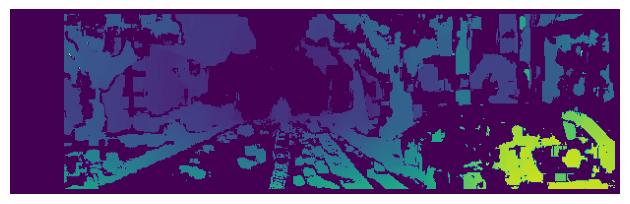

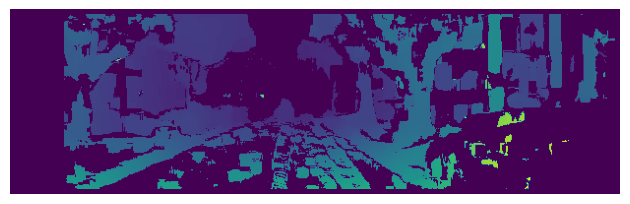

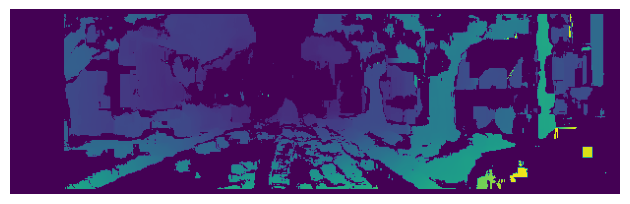

In [13]:
# Optional (only if fast enough): Disparity movie
warnings.warn('Visualizing disparity over sequence! This is optional and could take a lot of time (100 stereo pairs)!')

maxi = 9 # 99
for i in range(0,maxi,2):
    l = cv2.resize(cv2.imread('./data/left/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE), None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    r = cv2.resize(cv2.imread('./data/right/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE), None,fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

    disp_img_i = getDisparity(l, r, patch_radius, min_disp, max_disp)

    plt.clf()
    plt.imshow(disp_img_i)
    plt.axis('off')
    plt.tight_layout()

    plt.pause(0.1)

/tmp/ipykernel_655/4090161887.py:16: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7


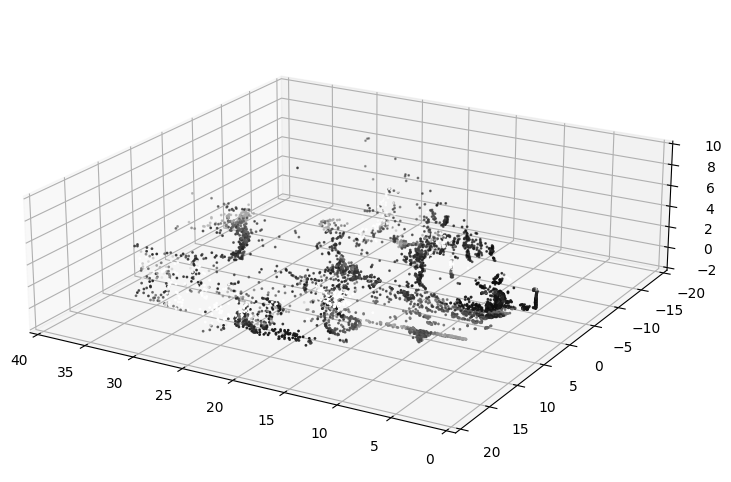

In [16]:
# Part 3: Create point cloud for first pair
p_C_points, intensities = disparityToPointCloud(disp_img, K, baseline, left_img)
T_C_F = np.asarray([[0, -1, 0],
                    [0, 0, -1],
                    [1, 0, 0]])
p_F_points = np.matmul(np.linalg.inv(T_C_F), p_C_points[::11, :, None]).squeeze(-1)
intensities = intensities[::11]
intensities = np.tile(intensities[:, None], (1, 3)) / 255

fig = plt.figure(figsize=(24,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(p_F_points[:, 0], p_F_points[:, 1], p_F_points[:, 2], s=1, c=intensities)
ax.set_box_aspect((1, 1, 12/40))

ax.azim = 120
ax.dist = 7
ax.elev = 20

ax.axes.set_xlim3d(left=0, right=40)
ax.axes.set_ylim3d(bottom=-20, top=20)
ax.axes.set_zlim3d(bottom=-2, top=10)

plt.show()

/tmp/ipykernel_655/2612269124.py:2: UserWarning: Visualizing pointcloud over sequence! This is optional and could take a lot of time (100 stereo pairs)!
  warnings.warn('Visualizing pointcloud over sequence! This is optional and could take a lot of time (100 stereo pairs)!')
/tmp/ipykernel_655/2612269124.py:27: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 7


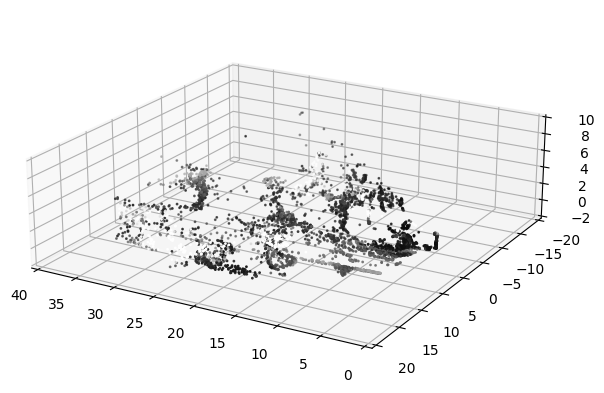

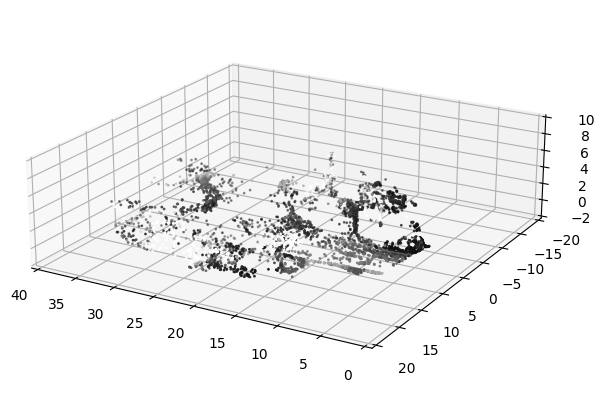

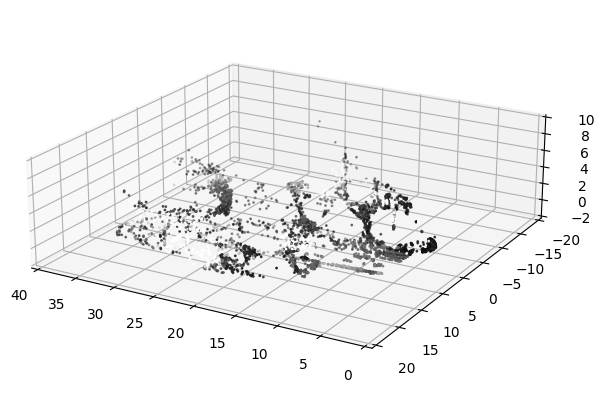

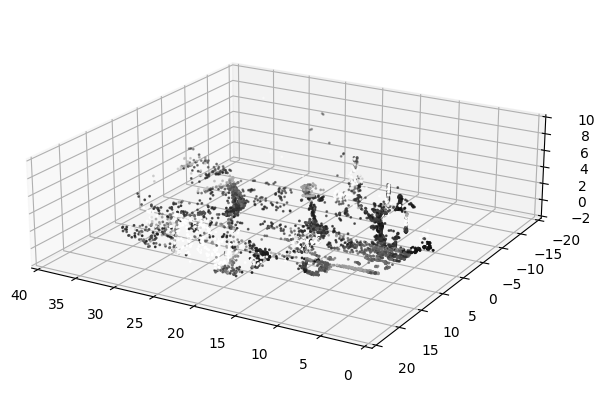

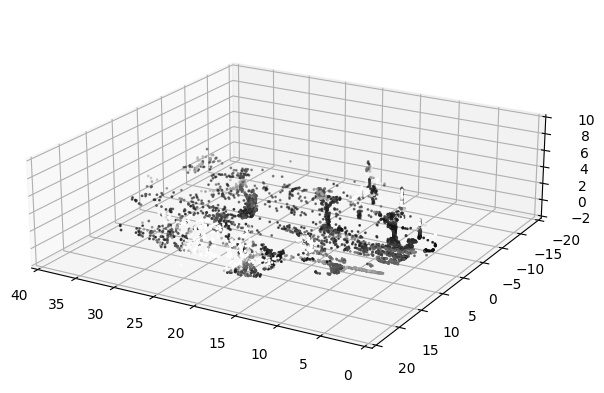

In [17]:
# Visualize point clouds over sequence
warnings.warn('Visualizing pointcloud over sequence! This is optional and could take a lot of time (100 stereo pairs)!')

maxi = 9 #99
for i in range(0,maxi,2):
    l = cv2.resize(cv2.imread('./data/left/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE), None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)
    r = cv2.resize(cv2.imread('./data/right/{0:06d}.png'.format(i), cv2.IMREAD_GRAYSCALE), None, fx=0.5, fy=0.5, interpolation=cv2.INTER_LINEAR)

    disp_img_i = getDisparity(l, r, patch_radius, min_disp, max_disp)

    p_C_points, intensities = disparityToPointCloud(disp_img_i, K, baseline, l)
    T_C_F = np.asarray([[0, -1, 0],
                        [0, 0, -1],
                        [1, 0, 0]])
    p_F_points = np.matmul(np.linalg.inv(T_C_F), p_C_points[::11, :, None]).squeeze(-1)
    intensities = intensities[::11]
    intensities = np.tile(intensities[:, None], (1, 3)) / 255

    plt.clf()
    plt.close()
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(p_F_points[:, 0], p_F_points[:, 1], p_F_points[:, 2], s=1, c=intensities)
    ax.set_box_aspect((1, 1, 12/40))

    ax.azim = 120
    ax.dist = 7
    ax.elev = 20

    ax.axes.set_xlim3d(left=0, right=40)
    ax.axes.set_ylim3d(bottom=-20, top=20)
    ax.axes.set_zlim3d(bottom=-2, top=10)

    plt.show()